In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
import torchvision
import monai
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('bmh')
import pathlib, random, itertools, collections, math, json
print('TORCH', torch.__version__)
print('TORCHVISION', torchvision.__version__)
print('MONAI', monai.__version__)
np.random.seed(0)

In [2]:
med = pathlib.Path('/mnt/dfs/qtim/clu/data/MedMNIST/')

In [3]:
results_path = pathlib.Path('/mnt/dfs/qtim/clu/ISBI/results/')
figures_path = pathlib.Path('/mnt/dfs/qtim/clu/ISBI/figures/')
results_path.mkdir(exist_ok=True)
figures_path.mkdir(exist_ok=True)

In [4]:
for x in list(med.iterdir()):
    labels = np.load(x)['train_labels']
    print(x.stem, len(np.unique(labels)), len(labels), sep='\t')

chestmnist	2	78468
breastmnist	2	546
dermamnist	7	7007
octmnist	4	97477
organmnist_axial	11	34581
organmnist_coronal	11	13000
organmnist_sagittal	11	13940
pneumoniamnist	2	4708
retinamnist	5	1080
pathmnist	9	89996
organmnist3d	11	972
nodulemnist3d	2	1158
organsmnist	11	13940
bloodmnist	8	11959
organamnist	11	34581
adrenalmnist3d	2	1188
tissuemnist	8	165466
organcmnist	11	13000
vesselmnist3d	2	1335
synapsemnist3d	2	1230
fracturemnist3d	3	1027


In [5]:
def load_data(dataset):
    data = np.load(med / f'{dataset}.npz')
    if dataset == 'organmnist3d':  # image is all zero; exclude from set
        train_images = np.concatenate([data['train_images'][:792], data['train_images'][793:]], axis=0)
        train_labels = np.concatenate([data['train_labels'][:792], data['train_labels'][793:]], axis=0)
    else:
        train_images = data['train_images']
        train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']
    return dict(
        train_images=train_images, 
        train_labels=train_labels,
        val_images=val_images,
        val_labels=val_labels,
        test_images=test_images,
        test_labels=test_labels,
    )

In [6]:
K = 0

datasets = ['bloodmnist', 'dermamnist', 'pathmnist', 'tissuemnist', 'retinamnist', 'organmnist3d']
data = load_data(datasets[K])
train_images=data['train_images']
train_labels=data['train_labels']
val_images=data['val_images']
val_labels=data['val_labels']
test_images=data['test_images']
test_labels=data['test_labels']

def get_class_counts(datasets=datasets):
    class_distributions = {}
    number_of_examples = {}
    for dataset in datasets:
        data = load_data(dataset)
        train_labels=data['train_labels']
        val_labels=data['val_labels']
        test_labels=data['test_labels']
        all_labels = np.concatenate([
            train_labels,
            val_labels,
            test_labels,
        ]).flatten()
        class_distributions[dataset] = np.bincount(all_labels)
        number_of_examples[dataset] = all_labels.shape
    return class_distributions, number_of_examples

class_distributions, number_of_examples = get_class_counts()

num_class = len(np.unique(train_labels))
use_3d = True if '3d' in datasets[K] else False
dataset = datasets[K]

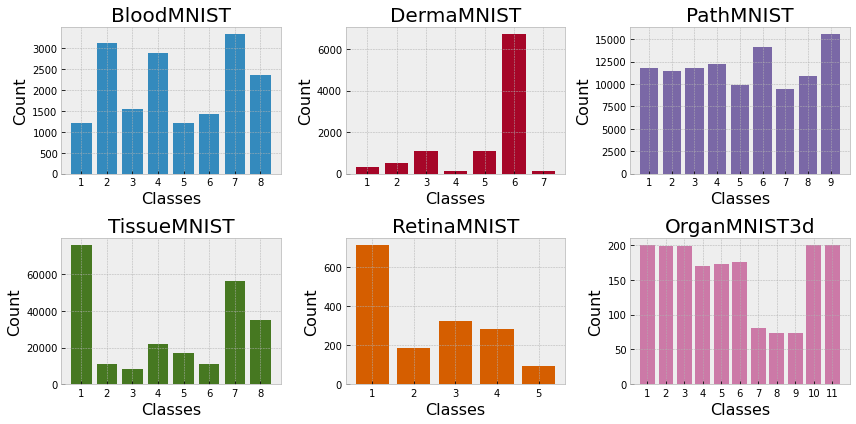

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
for i in range(2):  # rows
    for j in range(3):  # columns
        name = datasets[i * 3 + j]
        distribution = class_distributions[name]
        examples = number_of_examples[name][0]
        number_of_classes = distribution.shape[0]
        title = name.capitalize().replace('mnist', 'MNIST')
        ax = axes[i, j]
        ax.bar(range(1, number_of_classes + 1), distribution, color=f'C{i * 3 + j}')
        ax.set_xticks(range(1, number_of_classes + 1))
        ax.set_title(f'{title}', fontsize=20)
        ax.set_xlabel('Classes', fontsize=16)
        ax.set_ylabel('Count', fontsize=16)
#         ax.legend(loc='upper right', fontsize=16)
fig.tight_layout()
plt.savefig(figures_path / 'class_distribution')

In [8]:
print(datasets[K].upper().center(30, '='))
print('TRAIN\t', train_images.shape[0])
print('VALID\t', val_images.shape[0])
print('TEST\t', test_images.shape[0])

==========BLOODMNIST==========
TRAIN	 11959
VALID	 1712
TEST	 3421


In [9]:
dataset

'bloodmnist'

In [10]:
# k = 0
# plt.imshow(train_images[k, 10])
# plt.imshow(train_images[k])
# plt.title(train_labels.flatten()[k])

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, use_3d=False):
        self.images = images
        self.labels = labels
        self.use_3d = use_3d
    
    def __getitem__(self, index: int):
        image = self.images[index].astype(np.float32)
        image -= image.mean()
        image /= image.std()
        if image.ndim == 3:
            if self.use_3d:
                image = image[None]
                image = np.repeat(image, 3, axis=0)
            else:
                image = np.moveaxis(image, -1, 0)
        elif image.ndim == 2:
            image = image[None]
            image = np.repeat(image, 3, axis=0)
        label = self.labels[index].astype(int).squeeze()
        return image, label
        
    def __len__(self) -> int:
        return self.images.shape[0]
    
def wrap_loader(
        dataset,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=8,
        **kwargs,
    ):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
        pin_memory=pin_memory,
        num_workers=num_workers,
        **kwargs,
    )

In [12]:
def initialize_weights(model):
    for layer in model.modules():
        if isinstance(layer, (torch.nn.Conv2d, torch.nn.Conv3d)):
            torch.nn.init.xavier_uniform_(layer.weight)
            
def get_model(num_class=1, use_3d=False):
    model = monai.networks.nets.resnet10(spatial_dims=3 if use_3d else 2)
    initialize_weights(model)
    in_channels = model.conv1.in_channels
    out_channels = model.conv1.out_channels
    if use_3d:
        model.conv1 = torch.nn.Conv3d(in_channels, out_channels, kernel_size=1)
    else:
        model.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
    model.fc = torch.nn.Linear(model.fc.in_features, num_class)
    return model

In [18]:
def get_entropy(datasets=datasets, use_3d=use_3d, lr=1e-5):
    test_scores = collections.defaultdict(dict)
    test_entropy = collections.defaultdict(dict)
    for dataset in datasets:
        data = load_data(dataset)
        train_labels=data['train_labels']
        val_labels=data['val_labels']
        test_labels=data['test_labels']
        
        # use to train model to estimate uncertainty
        N = round(train_images.shape[0] * 0.1)
        
        model = get_model(num_class=len(np.unique(train_labels)), use_3d=use_3d)
        initialize_weights(model)
        model = model.cuda()
        
        crit = torch.nn.CrossEntropyLoss()
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        model.train()
        
        for x, y in Dataset(train_images[:N], train_labels[:N], use_3d=use_3d):
            x = torch.tensor(x[None]).cuda()
            y = torch.tensor(y[None]).cuda()
            model.zero_grad()
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            
        model.eval()
        for i, (x, y) in enumerate(Dataset(test_images, test_labels, use_3d=use_3d)):
            x = torch.tensor(x[None]).cuda()
            test_scores[dataset][i] = torch.softmax(model(x), 1).detach().cpu().tolist()[0]
            
    def entropy(prob, e=1e-8):
        ent = [p * math.log(p + 1e-8) for p in prob]
        return -sum(ent) / len(ent)

    for k, v in test_scores.items():
        test_entropy[k] = {k: entropy(v) for k, v in v.items()}
        
    del model
            
    return test_scores, test_entropy

In [19]:
test_scores, test_entropy = get_entropy(datasets, use_3d)

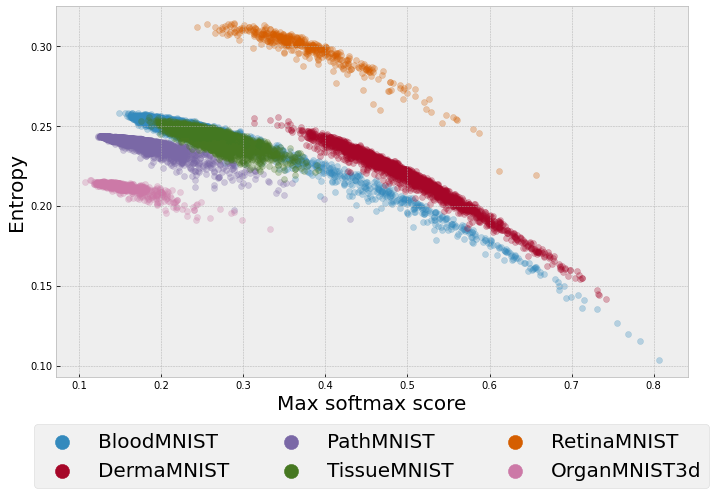

In [111]:
plt.figure(figsize=(10, 7))
# plt.title('Correlation between entropy and softmax', fontsize=24)
for i, dataset in enumerate(datasets):
    x = np.array(list({k: max(v) for k, v in test_scores[dataset].items()}.values()))
    y = np.array(list(test_entropy[dataset].values()))
    plt.scatter(
        x,
        y,
        marker='o',
        alpha=0.3,
#         color=f'C{i * 3 + j}',
        label=dataset.capitalize().replace('mnist', 'MNIST'),
    )
#     ax.set_xticks(range(1, number_of_classes + 1))
#     ax.set_title(f'{title}', fontsize=20)
    plt.xlabel('Max softmax score', fontsize=20)
    plt.ylabel('Entropy', fontsize=20)
#     plt.ylim(0, 1)
#     m, b = np.polyfit(x, y, 1)
#     x_min, x_max = x.min(), x.max()
#     plt.plot([x_min, x_max], [m*x_min + b, m*x_max + b], label=f'{dataset}', ls='--', color=f'C{i}')
               
leg = plt.legend(fontsize=20, bbox_to_anchor=(-0.05, -0.4, 1.1, .3), ncol=3, mode='expand')
for lh in leg.legendHandles: 
    lh.set_sizes([200])
    lh.set_alpha(1)
    
plt.tight_layout()
plt.savefig(figures_path / 'entropy')

In [55]:
def get_partition(arr, k=2, max_size=None):
    n = arr.shape[0]
    x = np.random.permutation(n)
    k_n = n // k
    indexes = [x[i*k_n:(i*k_n) + k_n] for i in range(k)]
    if max_size is not None:
        indexes = [index[:max_size] for index in indexes]
    return indexes

def add_label_noise(images, labels, percent_noise=0.30):
    size = images.shape[0]
    index = np.arange(size)
    cutoff = round(size * percent_noise)
    noise_index = np.random.permutation(index[:cutoff])
    clean_index = index[cutoff:]
    new_index = np.concatenate([noise_index, clean_index])
    return images, labels[new_index]

In [56]:
def inference(model, dataset):
    model.eval(); loss = 0; pred = []; label = []
    for i, (x, y) in enumerate(dataset):
        with torch.no_grad():
            logits = model(torch.tensor(x).to('cuda')[None])
            loss = crit(logits, torch.tensor(y[None]).to('cuda'))
            pred.append(torch.softmax(logits, 1).detach().cpu().tolist()[0])
            label.append(y.tolist())
            loss += loss.detach().cpu().item()
    loss /= len(dataset)
    return pred, label, loss

def pred_accuracy(pred, labels):
    corr = 0; count = 0
    for prob, label in zip(pred, labels):
        pred = np.argmax(prob)
        corr += 1 if pred == label else 0
        count += 1
    return corr / count

In [57]:
def get_q_hat(calibration_scores, labels, alpha=0.05):
    if not isinstance(calibration_scores, torch.Tensor):
        calibration_scores = torch.tensor(calibration_scores)
    n = calibration_scores.shape[0]
    #  sort scores and returns values and index that would sort classes
    values, indices = calibration_scores.sort(dim=1, descending=True)
    #  sum up all scores cummulatively and return to original index order 
    cum_scores = values.cumsum(1).gather(1, indices.argsort(1))[range(n), labels]
    #  get quantile with small correction for finite sample sizes
    q_hat = torch.quantile(cum_scores, np.ceil((n + 1) * (1 - alpha)) / n)
    return q_hat

def conformal_inference(scores, q_hat):
    if not isinstance(scores, torch.Tensor):
        scores = torch.tensor(scores)
    if q_hat >= 1:
        q_hat -= 1e-4
    n = scores.shape[0]
    values, indices = scores.sort(dim=1, descending=True)
    #  number of each confidence prediction set to acheive coverage
    set_sizes = (values.cumsum(1) > q_hat).int().argmax(dim=1)
    confidence_sets = [indices[i][0:(set_sizes[i] + 1)] for i in range(n)]
    return [x.tolist() for x in confidence_sets]

In [58]:
def accuracy(pred_sets, labels):
    corr = 0; count = 0
    for pred, label in zip(pred_sets, labels):
        corr += 1 if label == pred[0] else 0
        count += 1
    return corr / count

def validity(pred_sets, labels):
    corr = 0; count = 0
    for pred, label in zip(pred_sets, labels):
        corr += 1 if label in pred else 0
        count += 1
    return corr / count
        
def cardinality(pred_sets):
    sizes = []
    for pred in pred_sets:
        sizes.append(len(pred))
    return sum(sizes) / len(sizes)

In [ ]:
RUNS = 10
run_results = {}

global_model = get_model(num_class, use_3d)

for seed in range(RUNS):
    torch.manual_seed(seed)

    # PARAMS
    partitions = [1, 2, 4, 8]
    batch_size = 16
    lr = 1e-5
    rounds = 5
    alphas = np.arange(0.1, 1.0, 0.1)
    precision = 3
    percent_noise = 0.3

    local_results = collections.defaultdict(dict)

    for p in partitions:
        num_local = p
        max_partitions = partitions[-1]
        max_size = train_images[N:].shape[0] // max_partitions
        local_train = dict(enumerate(get_partition(train_images[N:], k=num_local, max_size=max_size)))
        local_val = dict(enumerate(get_partition(val_images, k=num_local)))
        local_test = dict(enumerate(get_partition(test_images, k=num_local)))
        local_indexes = {
            k: [local_train[k], local_val[k], local_test[k]] for k in range(num_local)
        }
        loaders = collections.defaultdict(dict)
        for k, (train_index, val_index, test_index) in local_indexes.items():
            images = train_images[train_index]
            labels = train_labels[train_index]
            if num_local > 1 and k != 0:
                images, labels = add_label_noise(images, labels, percent_noise=percent_noise)
            train = wrap_loader(Dataset(images, labels, use_3d=use_3d), batch_size=batch_size, shuffle=True)
            images = val_images[val_index]
            labels = val_labels[val_index]
            val = wrap_loader(Dataset(images, labels, use_3d=use_3d), batch_size=batch_size)
            images = test_images[test_index]
            labels = test_labels[test_index]
            test = wrap_loader(Dataset(images, labels, use_3d=use_3d), batch_size=batch_size)
            loaders[k] = {'train': train, 'val': val, 'test': test}
        test_scores = collections.defaultdict(dict)
        initialize_weights(global_model)
        global_model = global_model.cuda()
        global_model.eval()
        for k, v in loaders.items():
            for i, (x, y) in enumerate(v['test'].dataset):
                x = torch.tensor(x[None]).cuda()
                test_scores[k][i] = torch.softmax(global_model(x), 1).detach().cpu().tolist()[0]
        entropy_scores = {k: {j: entropy(w) for j, w in v.items()} for k, v in test_scores.items()}
        global_model = global_model.cpu()
        local_models = collections.defaultdict(dict)
        for k in range(num_local):
            model = get_model(num_class, use_3d)
            crit = torch.nn.CrossEntropyLoss()
            opt = torch.optim.Adam(model.parameters(), lr=lr)
            local_models[k] = {'model': model, 'crit': crit, 'opt': opt}

        train_losses = collections.defaultdict(list)
        val_losses = collections.defaultdict(list)

        for r in range(rounds):
            for k, v in local_models.items():
                train_loader = loaders[k]['train']
                val_loader = loaders[k]['val']
                test_loader = loaders[k]['test']

                model = v['model'].cuda()
                crit = v['crit']
                opt = v['opt']

                train_loss = 0; model.train()
                for i, (x, y) in enumerate(train_loader):
                    model.zero_grad()
                    logits = model(x.to('cuda'))
                    loss = crit(logits, y.to('cuda'))
                    loss.backward()
                    opt.step()
                    train_loss += loss.detach().cpu().item()
                train_loss /= len(train_loader)
                train_losses[k].append(train_loss)

                val_loss = 0; model.eval()
                for i, (x, y) in enumerate(val_loader):
                    with torch.no_grad():
                        logits = model(x.to('cuda'))
                        loss = crit(logits, y.to('cuda'))
                        val_loss += loss.detach().cpu().item()
                val_loss /= len(val_loader)
                val_losses[k].append(val_loss)

                # fed averaging
                for k in global_model.state_dict().keys():
                    temp = torch.zeros_like(global_model.state_dict()[k])
                    for v in  local_models.values():
                        temp += v['model'].cpu().state_dict()[k] 
                    global_model.state_dict()[k] = temp / torch.tensor(num_local, dtype=float)

                # copy to local models
                for i, v in local_models.items():
                    model = v['model']
                    for k in global_model.state_dict().keys():
                        model.state_dict()[k] = global_model.state_dict()[k]
                    local_models[i]['model'] = model

        local_results[f'part-{p}']['loss'] = {'train': train_losses, 'val': val_losses}

        local_pred = collections.defaultdict(dict)
        for k, v in local_models.items():
            model = v['model'].cuda()
            val_loader = loaders[k]['val']
            test_loader = loaders[k]['test']
            val_pred, val_label, val_loss = inference(model, val_loader.dataset)
            test_pred, test_label, test_loss = inference(model, test_loader.dataset)
            local_pred[k] = {
                'val_pred': val_pred,
                'test_pred': test_pred,
                'val_label': val_label,
                'test_label': test_label,
            }

        local_results[f'part-{p}']['pred'] = local_pred

        avg_test_acc = []
        for k, v in local_pred.items():
            val_pred, val_label = v['val_pred'], v['val_label']
            test_pred, test_label = v['test_pred'], v['test_label']

            avg_test_acc.append(pred_accuracy(test_pred, test_label))
        local_results[f'part-{p}']['acc'] = np.mean(avg_test_acc)

        conformal_results = collections.defaultdict(dict)
        entropy_results = collections.defaultdict(dict)
        for alpha in alphas:
            conformal_values = collections.defaultdict(dict)
            conformal_sets = collections.defaultdict(dict)

            avg_acc = []
            avg_val = []
            avg_car = []
            for k, v in local_pred.items():
                val_pred, val_label = v['val_pred'], v['val_label']
                conformal_values[k] = get_q_hat(val_pred, val_label, alpha=alpha)
                conformal_sets[k] = conformal_inference(v['test_pred'], conformal_values[k])
                acc = accuracy(conformal_sets[k], v["test_label"])
                valid = validity(conformal_sets[k], v["test_label"])
                card = cardinality(conformal_sets[k])
                conformal_results[round(alpha, 2)][k] = acc, valid, card
                avg_acc.append(acc)
                avg_val.append(valid)
                avg_car.append(card)
            if round(alpha, 2) == 0.2:
                print('AVERAGE'.center(20, '='), 
                      round(np.mean(avg_acc), precision), 
                      round(np.mean(avg_val), precision), 
                      round(np.mean(avg_car), precision),
                     )
            for k, v in entropy_scores.items():
                p_90 = np.quantile(list(v.values()), 0.90)
                p_95 = np.quantile(list(v.values()), 0.95)
                p_99 = np.quantile(list(v.values()), 0.99)
                ent_90 = {j: w for j, w in v.items() if w > p_90}
                ent_95 = {j: w for j, w in v.items() if w > p_95}
                ent_99 = {j: w for j, w in v.items() if w > p_99}
                for i, pred in conformal_sets.items():
                    if i == k:
                        entropy_results[alpha][k] = cardinality([pred[i] for i in ent_90.keys()])
                        entropy_results[alpha][k] = cardinality([pred[i] for i in ent_95.keys()])
                        entropy_results[alpha][k] = cardinality([pred[i] for i in ent_99.keys()])

        local_results[f'part-{p}']['conformal'] = conformal_results
        local_results[f'part-{p}']['entropy'] = entropy_results

    run_results[seed] = dict(local_results)

with open (results_path / f'heavy-noise-{dataset}-results.json', 'w') as f:
    f.write(json.dumps(run_results, indent=2))

======AVERAGE======= 0.773 0.992 3.738
======AVERAGE======= 0.742 0.976 3.404
======AVERAGE======= 0.763 0.983 3.547
======AVERAGE======= 0.765 0.987 3.584
======AVERAGE======= 0.761 0.994 3.818
======AVERAGE======= 0.756 0.981 3.44
======AVERAGE======= 0.758 0.987 3.663
======AVERAGE======= 0.759 0.991 3.976
======AVERAGE======= 0.768 0.993 4.34
======AVERAGE======= 0.756 0.985 3.475
======AVERAGE======= 0.75 0.988 3.619
======AVERAGE======= 0.756 0.989 3.802
======AVERAGE======= 0.766 0.995 3.726
======AVERAGE======= 0.749 0.981 3.385
======AVERAGE======= 0.763 0.987 3.88
======AVERAGE======= 0.764 0.988 3.748
======AVERAGE======= 0.778 0.992 3.581
======AVERAGE======= 0.737 0.98 3.47
======AVERAGE======= 0.769 0.987 3.546
======AVERAGE======= 0.765 0.988 3.879
======AVERAGE======= 0.767 0.992 3.928
======AVERAGE======= 0.754 0.984 3.981
======AVERAGE======= 0.766 0.98 3.719
======AVERAGE======= 0.774 0.988 3.648
======AVERAGE======= 0.773 0.989 3.839
======AVERAGE======= 0.748 0.987